In [1]:
import os
import json
import numpy as np
import heapq
from matplotlib import colors
import matplotlib.pyplot as plt
import torch
import networkx as nx
from networkx.readwrite import json_graph

In [2]:
os_path = "figures/"

# 1. Make Graph

In [3]:
def make_graph(num_nodes, num_edges):
    G = nx.DiGraph()

    nodes = [(chr(65 + (i-65)//26) + chr(65 + (i-65)%26)) for i in range(65, 65+num_nodes)]
    G.add_nodes_from(nodes)
    edges = [(np.random.choice(nodes), np.random.choice(nodes), np.random.randint(1, 100)) for _ in range(num_edges)]
    
    while True:
        edges = list(set(edges))
        if len(edges) == num_edges:
            break
        edges.append((np.random.choice(nodes), np.random.choice(nodes), np.random.randint(100)))
    
    for u, v, w in edges:
        G.add_edge(u, v, weight=w)
    
    heuristic_table = {node : np.random.randint(0,10) for node in nodes}

    return G, nodes, edges, heuristic_table

In [57]:
def plot_graph(G, path = None, start = None, goal = None, checking_edges = None, weight_tag = True, llm_nodes = None):

    pos = nx.spring_layout(G, seed=42)

    plt.figure(figsize=(12, 8))

    nx.draw_networkx_edges(G, pos, edge_color='gray', alpha=0.5, arrows=True,
                        connectionstyle='arc3,rad=0.1')

    nx.draw_networkx_nodes(G, pos, node_size=400, node_color='lightblue')
    nx.draw_networkx_labels(G, pos, font_size=8, font_weight='bold')

    if path is not None:
        nx.draw_networkx_nodes([start], pos, node_size=400, node_color='yellow')
        nx.draw_networkx_nodes([goal], pos, node_size=400, node_color='green')
        path_edges = list(zip(path, path[1:]))

        print(f"A* 경로 : {path}")
        nx.draw_networkx_edges(G, pos, edgelist=checking_edges, edge_color='orange', alpha= 0.3, width=4,
                            arrows=True, connectionstyle='arc3,rad=0.1')
        nx.draw_networkx_edges(G, pos, edgelist=path_edges, edge_color='red', width=2,
                            arrows=True, connectionstyle='arc3,rad=0.1')
        if llm_nodes is None :
            title = f"A* Shortest Path from {start} to {goal}"
            
        else:
            title = f"LLM A* Shortest Path from {start} to {goal} (llm nodes = {llm_nodes})"
            nx.draw_networkx_nodes(llm_nodes, pos, node_size=400, node_color='red')
    else :
        title = "our graph"
        

    
    if weight_tag:
        edge_labels = nx.get_edge_attributes(G, 'weight')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='green')

    plt.title(title, fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(os_path+title+".png",dpi=200)
    plt.show()

In [52]:
llm_nodes
G.nodes

NodeView(('AA', 'AB', 'AC', 'AD', 'AE', 'AF', 'AG', 'AH', 'AI', 'AJ', 'AK', 'AL', 'AM', 'AN', 'AO', 'AP', 'AQ', 'AR', 'AS', 'AT', 'AU', 'AV', 'AW', 'AX', 'AY', 'AZ', 'BA', 'BB', 'BC', 'BD', 'BE', 'BF', 'BG', 'BH', 'BI', 'BJ', 'BK', 'BL', 'BM', 'BN', 'BO', 'BP', 'BQ', 'BR', 'BS', 'BT', 'BU', 'BV', 'BW', 'BX', 'BY', 'BZ', 'CA', 'CB', 'CC', 'CD', 'CE', 'CF', 'CG', 'CH', 'CI', 'CJ', 'CK', 'CL', 'CM', 'CN', 'CO', 'CP', 'CQ', 'CR', 'CS', 'CT', 'CU', 'CV', 'CW', 'CX', 'CY', 'CZ', 'DA', 'DB', 'DC', 'DD', 'DE', 'DF', 'DG', 'DH', 'DI', 'DJ', 'DK', 'DL', 'DM', 'DN', 'DO', 'DP', 'DQ', 'DR', 'DS', 'DT', 'DU', 'DV'))

In [10]:
num_nodes = 500
num_edges = 1000
G, nodes, edges, heuristic_table = make_graph(num_nodes, num_edges)

In [11]:
with open("graphs/large_scale_graph.json", "r") as json_file:
    j = json.load(json_file)

G = json_graph.node_link_graph(j)
nodes = G.nodes
edges = G.edges
heuristic_table = {node : np.random.randint(0,10) for node in nodes}

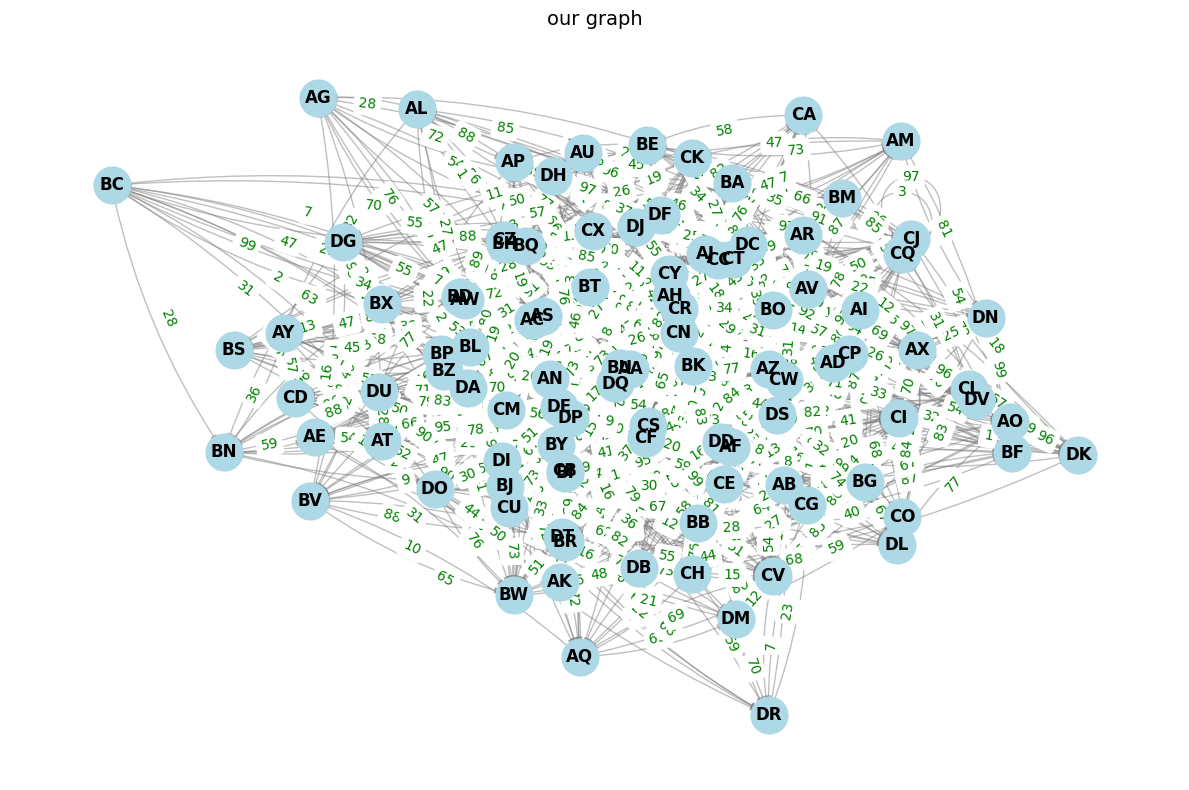

In [12]:
plot_graph(G)

In [13]:
#save graph as json
graph_json = json_graph.node_link_data(G)
with open("graphs/large_scale_graph.json", "w") as json_file:
    json.dump(graph_json, json_file)


# 2. A* Algorithm

In [14]:
def astar(G, start, goal, heuristic):
    count = 0
    checking_edges = set()

    open_set = []
    heapq.heappush(open_set, (heuristic[start], 0, start))

    came_from = {}
    g_score = {node: float('inf') for node in G.nodes}
    g_score[start] = 0

    f_score = {node: float('inf') for node in G.nodes}
    f_score[start] = heuristic[start]

    visited = set()

    while open_set:
        _, current_g, current = heapq.heappop(open_set)

        if current == goal:
            path = [current]
            while current in came_from:
                current = came_from[current]
                path.append(current)
            return path[::-1], current_g, count, list(checking_edges)

        visited.add(current)

        for neighbor in G.successors(current):
            count = count + 1
            if neighbor in visited:
                continue

            tentative_g = g_score[current] + G[current][neighbor]['weight']
            checking_edges.add((current, neighbor))
            if tentative_g < g_score[neighbor]:
                came_from[neighbor] = current
                g_score[neighbor] = tentative_g
                f_score[neighbor] = tentative_g + heuristic[neighbor]
                heapq.heappush(open_set, (f_score[neighbor], tentative_g, neighbor))

    return None, None, count, list(checking_edges)


# 3. LLM A* Algorithm

In [ ]:
def llm_astar(G, start, goal, heuristic, llm_nodes):

    points = llm_nodes.copy()
    points.insert(0, start)
    points.append(goal)

    cum = 0
    path = []
    count = 0
    checking_edges = set()

    for i in range(len(points)-1):
        s = points[i]
        e = points[i+1]

        open_set = []
        heapq.heappush(open_set, (heuristic[s], 0, s))

        came_from = {}
        g_score = {node: float('inf') for node in G.nodes}
        g_score[s] = 0

        f_score = {node: float('inf') for node in G.nodes}
        f_score[s] = heuristic[s]

        visited = set()

        while open_set:
            _, current_g, current = heapq.heappop(open_set)

            if current == e:
                p = [current]
                while current in came_from:
                    current = came_from[current]
                    p.append(current)
                path += p[::-1]
                if path[-1] in llm_nodes:
                    path.pop()
                cum += current_g
                break

            visited.add(current)

            for neighbor in G.successors(current):
                count = count + 1
                if neighbor in visited:
                    continue

                tentative_g = g_score[current] + G[current][neighbor]['weight']
                checking_edges.add((current, neighbor))
                if tentative_g < g_score[neighbor]:
                    came_from[neighbor] = current
                    g_score[neighbor] = tentative_g
                    f_score[neighbor] = tentative_g + heuristic[neighbor]
                    heapq.heappush(open_set, (f_score[neighbor], tentative_g, neighbor))

    return path, cum, count, list(checking_edges)


## Case 1 : AA to AN
### LLM nodes : 'CN'

Count :  509
Cost :  53
# of Checking edges 355
A* 경로 : ['AA', 'CN', 'DK', 'CB', 'AN']


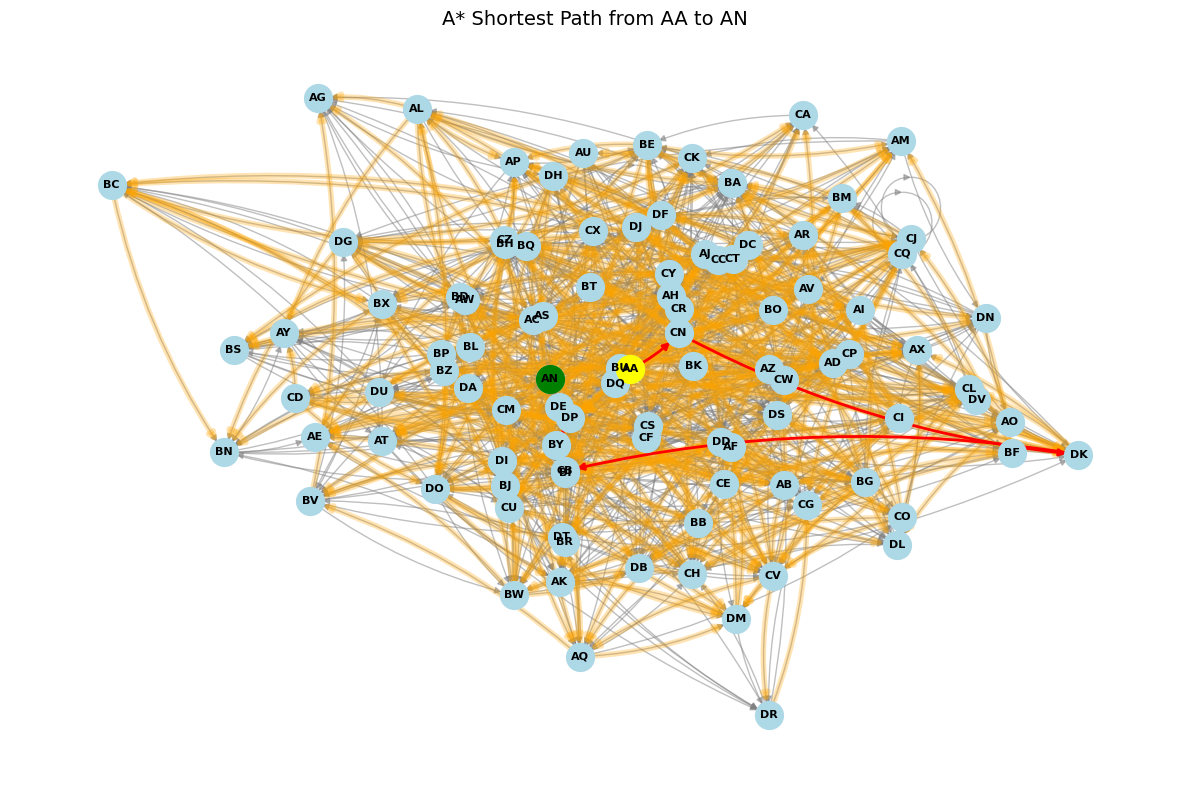

In [ ]:
start, goal = 'AA', 'AN'
path, cost, count, checking_edges= astar(G, start, goal, heuristic_table)
print("Count : ",count)
print("Cost : ",cost)
print("# of Checking edges", len(checking_edges))
plot_graph(G, path=path, start=start, goal=goal, checking_edges= checking_edges, weight_tag= False)

Count :  214
Cost :  53
# of Checking edges 177
A* 경로 : ['AA', 'CN', 'DK', 'CB', 'AN']


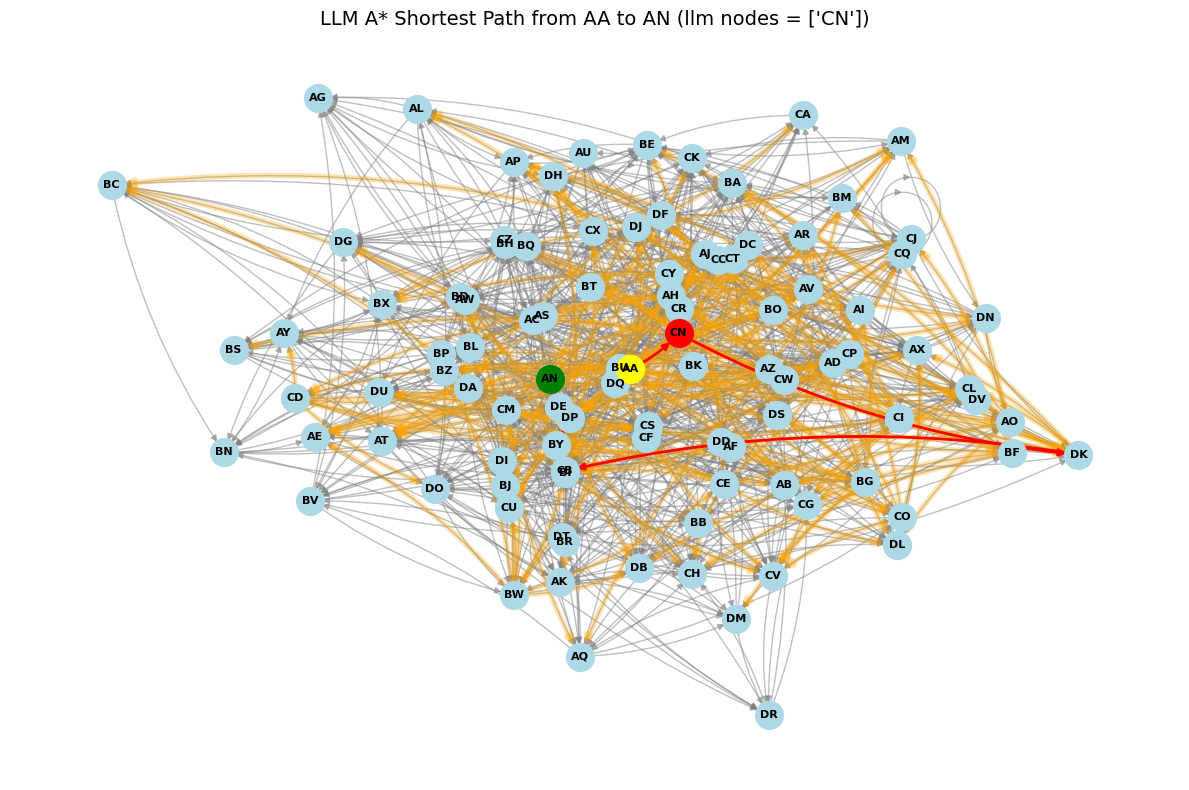

In [63]:
start, goal = 'AA', 'AN'
llm_nodes = ['CN']
path, cost, count, checking_edges= llm_astar(G, start, goal, heuristic_table, llm_nodes)
print("Count : ",count)
print("Cost : ",cost)
print("# of Checking edges", len(checking_edges))
plot_graph(G, path=path, start=start, goal=goal, checking_edges= checking_edges, weight_tag= False, llm_nodes = llm_nodes)

## Fail Case 1 : AA to BW
### LLM nodes: CO

Count :  102
Cost :  26
# of Checking edges 98
A* 경로 : ['AA', 'CN', 'AV', 'BW']


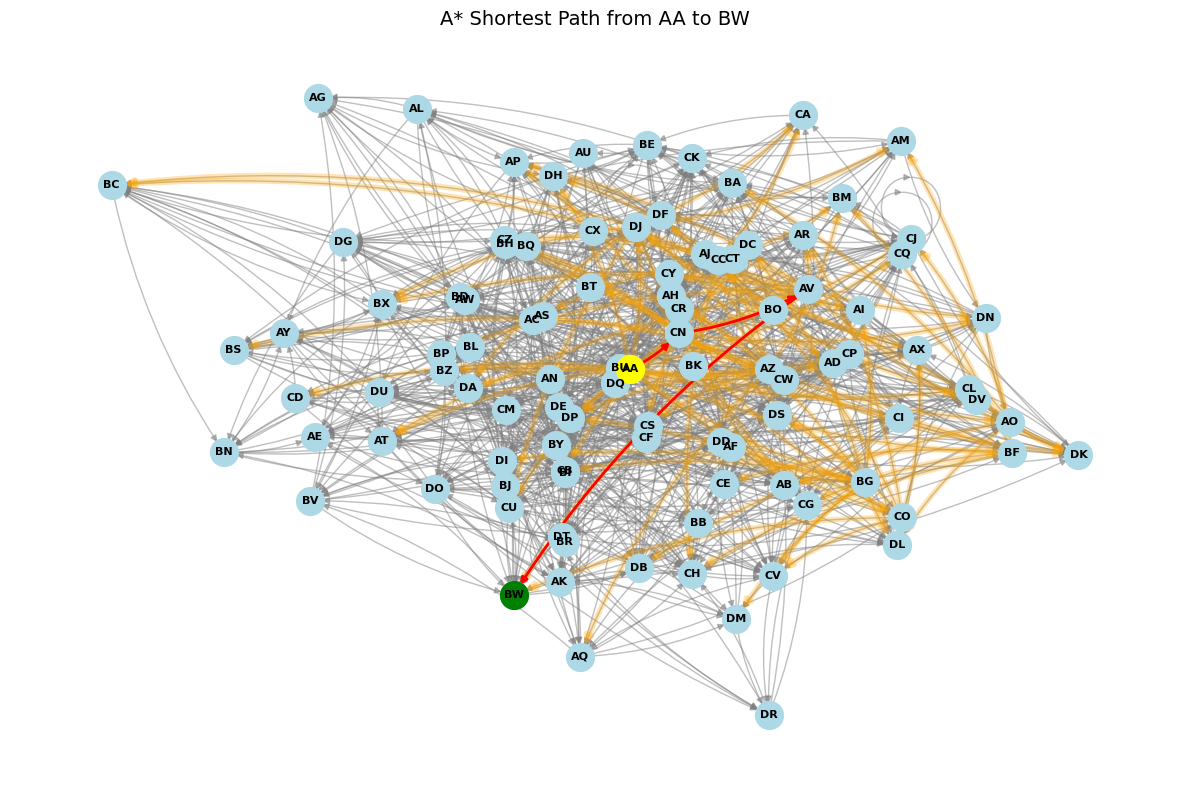

In [65]:
start, goal = 'AA', 'BW'
path, cost, count, checking_edges= astar(G, start, goal, heuristic_table)
print("Count : ",count)
print("Cost : ",cost)
print("# of Checking edges", len(checking_edges))
plot_graph(G, path=path, start=start, goal=goal, checking_edges= checking_edges, weight_tag= False)

Count :  84
Cost :  54
# of Checking edges 83
A* 경로 : ['AA', 'CO', 'BW']


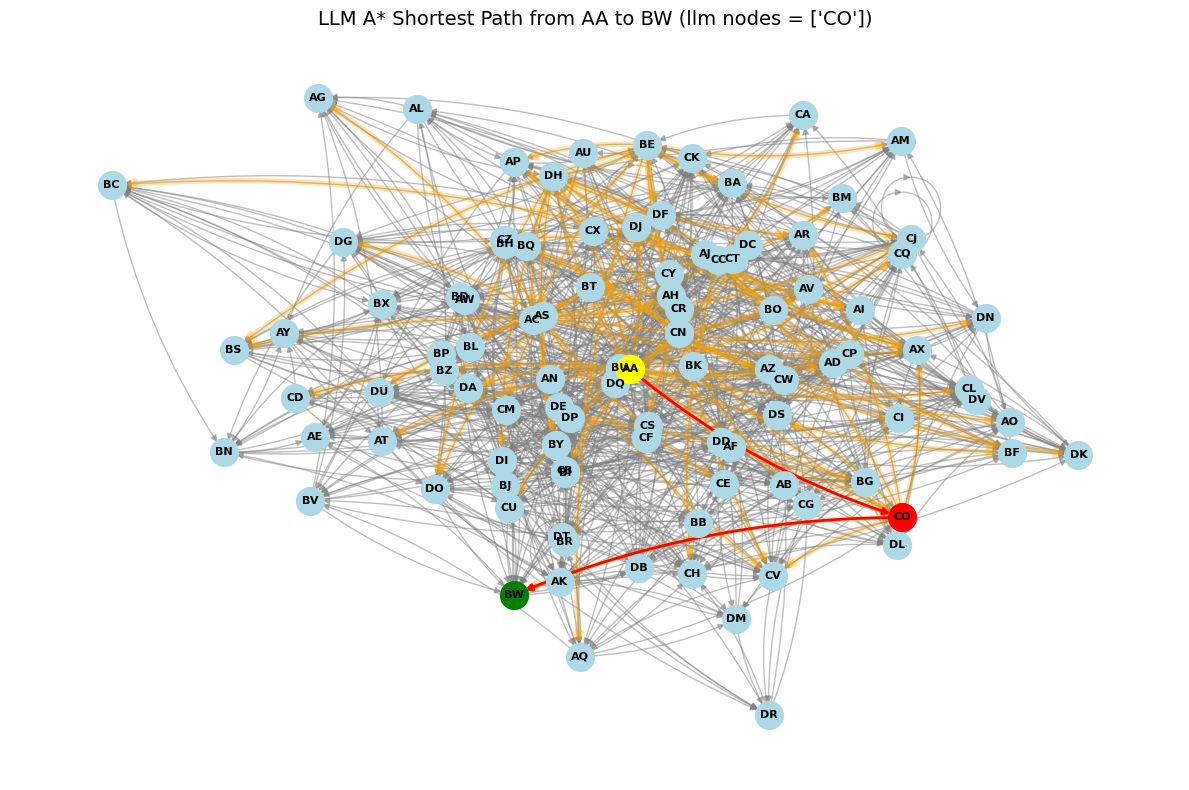

In [64]:
start, goal = 'AA', 'BW'
llm_nodes = ['CO']
path, cost, count, checking_edges= llm_astar(G, start, goal, heuristic_table, llm_nodes)
print("Count : ",count)
print("Cost : ",cost)
print("# of Checking edges", len(checking_edges))
plot_graph(G, path=path, start=start, goal=goal, checking_edges= checking_edges, weight_tag= False, llm_nodes = llm_nodes)